# Quantum Simulation of Linear Kinetic Plasma Models

This demonstration is based on the paper *[Encoding of Linear Kinetic Plasma Problems in Quantum Circuits via Data Compression](https://arxiv.org/abs/2403.11989)* [[1](#KineticPlasma)], and was created in collaboration with its authors. 

We explore how quantum algorithms can be used to solve a **linearized kinetic model of plasma**, focusing on a simplified **Vlasov–Ampère system** in one spatial dimension with an external electric field.

Plasmas — often called the **fourth state of matter** — are ionized gases consisting of charged particles. They exhibit rich collective behavior due to long-range electromagnetic interactions. Understanding and simulating plasmas is critical in many fields, especially in **nuclear fusion**, where plasma must be confined and controlled inside reactors such as **tokamaks** [[2](#Tok)].

Fusion energy aims to replicate the Sun's energy source on Earth. In magnetic confinement fusion (e.g., tokamaks), charged particles spiral along magnetic field lines. To predict plasma behavior in such systems, physicists use **kinetic equations**, which describe the full distribution of particle positions and velocities in phase space.

However, these models are **nonlinear** and **high-dimensional**, making simulations extremely expensive. To make progress, scientists often **linearize** the models around a known steady-state.

## The Vlasov–Ampère System

We consider a **linearized 1D Vlasov–Ampère system** with an external driving current. This system governs how perturbations to a background plasma evolve in phase space under the influence of electric fields.

The equations are:
$$
i \omega_0 g(x, v) - \zeta_{bc} \, v \, \partial_x g(x, v) - \partial_v f_0(v) E(x) = 0
$$

$$
i \omega_0 E(x) + \int v g(x,v) \, dv = j(x)
$$

### Physical Meaning and Assumptions

- **$g(x,v)$** is the first-order perturbation of the distribution function from equilibrium. It captures how particles deviate from their steady-state behavior: $f(x, v, t) = f_0(v) + g(x,v) e^{-i \omega_0 t}$.  Here we assume the background is homogeneous and so $f_0(v) = \frac{n_0}{\sqrt{2\pi T}} \exp\left(-\frac{v^2}{2T}\right)$.
- **$E(x)$** is the (complex) electric field.
- **$j(x)$** is a known source term (e.g. external driving or antenna).
- **$\zeta_{bc}$** encodes **non-reflecting boundary conditions**:
  - $\zeta_{bc} = 1$ for outgoing waves.
  - $\zeta_{bc} = 0$ for incoming waves.
- All variables in the equation were normalized such that we get dimensionless equations (see more details in the paper). 

---

Discretizing the variables $x$ and $v$ leads to very large linear systems. Upon discretization, they form a structured linear system suitable for **block encoding**, making them compatible with quantum linear solvers.

In the next sections, we will show how to construct block encoding for the equations using classiq, then plug it to a linear solver (QSVT in this case) to solve a certain toy problem.

We emphasize that due to the dependence of the linear system solver on the condition number - $O(\kappa \log(\frac{1}{\epsilon}))$, and the dependece of the condition number in the grid size, we don't expect any quantum advantage for the 1D system. However, generalizing for higher dimensional systems should be straightforward thanks to the high level modeling approach.

## Block Encoding of the linear system

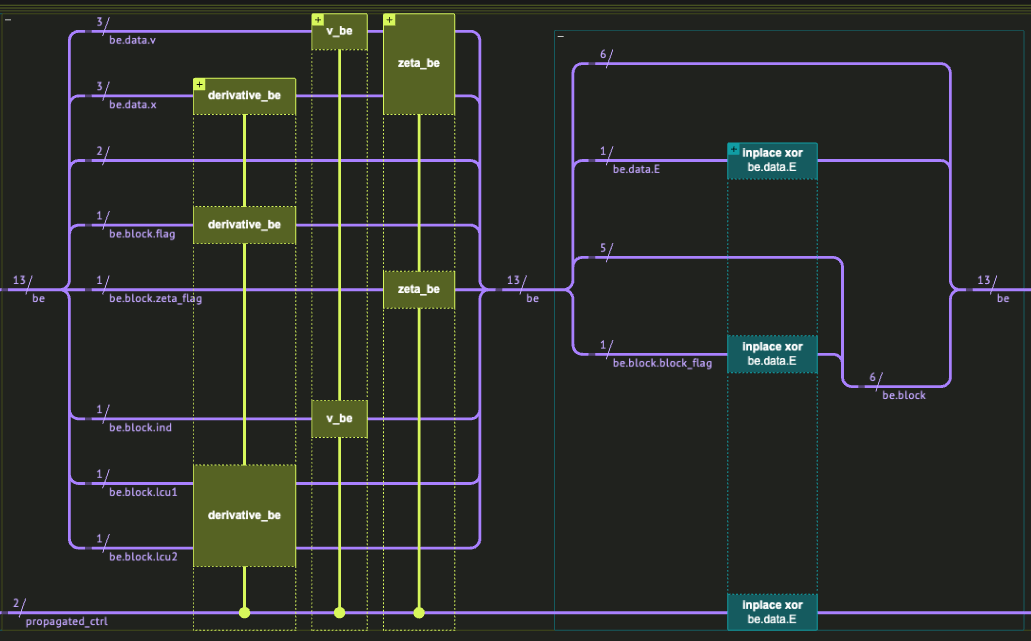

In the following section we describe how to assemble the block encoding of the equations using Classiq."Notice that in order to have a simulatable circuit, sometimes we use non-scallable functions that have better measures for small number of qubits - these are the arbitrary state preparation and amplitude assignment functions. However, we describe how to replace them with scalable alternatives.

First, choose the parameters of the problem:

In [1]:
!pip install -qq "classiq[qsp]"

In [2]:
import numpy as np

from classiq import *

In [3]:
# plasma parameters
Temperature = 1
N = 1  # simulate homogenous plasma - n(x) = 1

# source parameters
DS = 3
X_0 = 50
W_0 = 0.8

# grid  parameters
X_MIN = 0
X_MAX = 100

V_MIN = -4
V_MAX = 4

N_X = 3
N_V = 3

DX = (X_MAX - X_MIN) / (2**N_X - 1)
DV = (V_MAX - V_MIN) / (2**N_V - 1)

### Data encoding

We define a quantum struct that will define the mapping of the coordinates to the effective block-encoded matrix of the problem:

In [4]:
class BEData(QStruct):
    v: QNum[N_V, SIGNED, 0]
    x: QNum[N_X]
    E: QBit

`v` holds the velocity coordinate as a signed number, as the velocity can hold negative values as well.

`x` holds the position coordinates. It will encode a non-negative number in the range $[0, x_{max}]$

The value `E` switches between the encoding of $g(x, v)$ (for `E=0`) and $E(x)$ (for `E=1`, `v=0`). Notice that the values `E=1`, `v!=0` are redundant (in fact we could eliminate them through the projector of the block encoding, but we keep them as they don't change the reuslt).

#### Block Struct

We also add additional struct for the block encoding. It will hold additional variables that are required by the encoding process through - for adding block encodings (lcu), eliminating parts of existing block encodings (flag) or for diagonal block encoding (ind).

In [5]:
class BEBlock(QStruct):
    flag: QBit
    zeta_flag: QBit
    block_flag: QBit
    ind: QBit
    lcu1: QBit
    lcu2: QBit

Finally, the following struct will hold both defined structs:

In [6]:
class BE(QStruct):
    data: BEData
    block: BEBlock

---
Now we are ready to block encode all parts of the equation. We show how to block encode each part of them, then combine them with Linear Combination of Unitaries.

Let us look again on the equations:

$$
i \omega_0 g(x, v) - \zeta_{bc} \, v \, \partial_x g(x, v) - \partial_v f_0(v) E(x) = 0
$$

$$
i \omega_0 E(x) + \int v g(x,v) \, dv = j(x)
$$

The matrix we encode will have a row for each $g$'s degree of freedom, and a row for each $E$ dof. The columns represent the participating terms in each equation.

### Block encoding: advective term

Notice that the advective term $\zeta_{bc} \, v \, \partial_x g(x, v)$ is in the upper left corner of the block encoded matrix (as it only involves $g$). Ignoring $\zeta_{bc}$ part, the term is a tensor product of 2 block encodings - a diagonal $v$ encoding, and a derivative term.

#### Derivative term
The derivative term consists of normal finite-difference rule intermediate x points. At the boundaries of $x$, the derivative is according to a 2nd order interpolating polynomial (as described in the paper Eqs.19). 

We decompose it as a sum of 2 matrices:
$$\frac{1}{2\Delta x}\begin{pmatrix}
-3 & 4 & -1 & 0 & \cdots & 0 \\
-1 & 0 & 1 & 0 & \cdots & 0 \\
0 & -1 & 0 & 1 & \cdots & 0 \\
\vdots & \ddots & \ddots & \ddots & \ddots & \vdots \\
0 & \cdots & -1 & 0 & 1 & 0 \\
0 & \cdots & 0 & 1 & -4 & 3
\end{pmatrix} = 
\frac{1}{2\Delta x}\begin{pmatrix}
  0  & 1      &        &        &        \\
 -1  & 0      & 1      &        &        \\
     & -1     & 0      & \ddots &        \\
     &        & \ddots & \ddots & 1      \\
     &        &        & -1     & 0
\end{pmatrix}
+
\frac{1}{2\Delta x}\begin{pmatrix}
-3  & 3  & -1 & 0 & \cdots & 0 \\
0   & 0  & 0  & \cdots & \cdots & 0 \\
\vdots &    &    & \vdots \\
\vdots &    &    & \vdots \\
0   & 0  & 0  & 0 & \cdots & 0 \\
0   & 0  & 0  & 3 & -3 & 1
\end{pmatrix}$$

The first matrix is a 1D x-derivative with dirichlet boundary conditions. The 2 diagonals are combined using LCU of modular adders, where the overfolwing terms are eliminated using a flag qubit.

In [7]:
# derivative along x without boundary conditions


@qfunc
def derivative_dirichlet_be(x: QNum, flag: QBit, lcu_q: QBit):
    extended_qnum = QNum()
    within_apply(
        lambda: bind([x, flag], extended_qnum),
        lambda: lcu(
            [1, -1],
            [
                lambda: inplace_add(-1, extended_qnum),
                lambda: inplace_add(1, extended_qnum),
            ],
            lcu_q,
        ),
    )

For the boundary conditions matrix, we use a flag for applying it only on the first and last row. Additionaly, a control on the MSB of the `x` variable to take care for both edges of the system.

It is assumed that the size of `x` in qubits is at least 2.

In [8]:
BC_VALUES = 0.5 * np.array([-3, 3, -1, 0])
BC_NORM = np.linalg.norm(BC_VALUES)
BC_VALUES = BC_VALUES / BC_NORM

derivative along x on the boundaries:

In [9]:
from classiq.qmod.symbolic import pi


@qfunc
def prepare_bounday_x(x: QArray):
    inplace_prepare_amplitudes(BC_VALUES, 0.0, x[0:2])


@qfunc
def derivative_boundary_min_be(x: QNum, flag: QBit):
    invert(lambda: prepare_bounday_x(x))
    flag ^= x != 0


@qfunc
def derivative_boundaries_be(x: QArray, flag: QBit):
    within_apply(
        lambda: control(
            x[x.len - 1], lambda: apply_to_all(X, x[0 : x.len - 1])
        ),  # flip row order
        lambda: [
            control(x[x.len - 1], lambda: phase(pi)),  # phase of -1
            derivative_boundary_min_be(x[0 : x.len - 1], flag),
        ],
    )

Combine matrices to get the block-encoding of the derivative term:

In [10]:
@qfunc
def derivative_be(x: QNum, flag: QBit, lcu1: QBit, lcu2: QBit):
    lcu(
        [1, BC_NORM],
        [
            lambda: derivative_dirichlet_be(x, flag, lcu2),
            lambda: derivative_boundaries_be(x, flag),
        ],
        lcu1,
    )

#### Diagonal $v$ term
We use the `assign_amplitude_table` function, that performs the operation $|v\rangle|0\rangle_{ind} \rightarrow |v\rangle(f(v)|1\rangle_{ind} + \sqrt{1-f^2(v)}|0\rangle_{ind})$, which is exactly a diagonal block encoding, where the additional indicator part of the block qubits.

To save qubits we use implementation for arbitrary $f(v)$, which is not scallable to large variable sizes. However, it is possible to perform it with a linear scaling in the number of qubits, using a primitive that block encodes $f(v) = \sqrt{\frac{v}{v_{max}}}$ to the amplitude, using quantum comparator. To achieve the function $f(v)=\frac{v}{v_{max}}$, one can simply take the square of the block encoding, using qsvt or block encoding multiplication. For more details, see the [qsvt notebook](https:https://github.com/Classiq/classiq-library/blob/main/functions/qmod_library_reference/classiq_open_library/qsvt/qsvt.ipynb).

In [11]:
@qfunc
def v_be(v: QNum, ind: QBit):
    assign_amplitude_table(lookup_table(lambda n: n / (2 ** (v.size - 1)), v), v, ind)
    ind ^= 1

#### Non-reflecting boundary conditions

The $\zeta$ term is enforcing non-reflecting boundary conditions, not allowing incoming waves to the system:
$$
\xi_{\mathrm{bc}} \, |x,v\rangle =
\left(
\begin{cases}
0, & x = 0,\; v > 0,\\[4pt]
0, & x = 2^{n_x}-1,\; v < 0,\\[4pt]
1, & \text{otherwise}
\end{cases}
\right) |x,v\rangle .
$$

In [12]:
@qfunc
def zeta_be(x: QNum, v: QNum, flag: QBit):
    flag ^= (x == 0) & (v > 0)
    flag ^= (x == (2**x.size - 1)) & (
        v <= 0
    )  # instead of doing 'or', take advantage of the mutual exclusiveness of the conditions

Combine to the advective term block encoding. Since each block encoding uses different block qubits, it is possible to create their multiplication without additional block qubits.

In [13]:
@qfunc
def advective_be(be: BE):
    derivative_be(be.data.x, be.block.flag, be.block.lcu1, be.block.lcu2)
    v_be(be.data.v, be.block.ind)
    zeta_be(be.data.x, be.data.v, be.block.zeta_flag)
    be.block.block_flag ^= be.data.E  # eliminate the lower right block

Keep track of the normalization factor of each part of the block encoding:

In [14]:
DERIVATIVE_TERM_FACTOR = 2 * (1 + BC_NORM)
ADVECTIVE_TERM_FACTOR = DERIVATIVE_TERM_FACTOR * (V_MAX / (2 * DX))

### Block encoding: off diagonal terms

Block encode the force and current terms, corresponding to the upper right and lower left blocks. 

#### Loading the force term

In our setting $$\partial_v f_0(v) E(x) = \frac{v}{\sqrt{2 \pi}} \exp \left(- \frac{v^2}{2 } \right)$$ It is a column vector in the matrix, and to load it we have several options. One is to first load one of them ($v$ or $H(v))$ as a state, then use amplitude loading of the other one to create a block encoding of the multiplication. A second option that we use here is to directly prepare the state of the multiplication. The advantage is a better scaling factor. It can be performed as suggested [here](https://github.com/Classiq/classiq-library/blob/main/community/paper_implementation_project/quantum_state_preparation_without_coherent_arithmetic/stateprep_guassian_using_qsvt.ipynb) [[3](#QSVTPrep)] (though for this specific method there would still be a scaling factor issue). For simplicity we use here the general state preparation method (which is not scallable). 

Finally, we zero the columns for which `v != 0`, beacuse we want only columns that encode the field $E$.

In [15]:
from classiq.qmod.symbolic import sqrt

v_amplitudes = np.linspace(-1, 1 - 2 ** (-N_V + 1), 2**N_V) * V_MAX
v_amplitudes = np.roll(v_amplitudes, len(v_amplitudes) // 2)  # adjust to signed number
v_H_amplitudes = (
    v_amplitudes
    * np.exp(-(v_amplitudes**2) / (2 * Temperature))
    / (np.sqrt(2 * np.pi * Temperature))
)


@qfunc
def load_v_H_vector(v: QNum):
    inplace_prepare_amplitudes(-v_H_amplitudes / np.linalg.norm(v_H_amplitudes), 0, v)


@qfunc
def force_term_be(v: QNum, flag: QBit):
    flag ^= v != 0
    load_v_H_vector(v)

#### Current term

The current term is an integration, represented by row multiplication:
$$\int v g(x,v) \, dv$$

To load v, a linear state-preparation is enough. This can be done using the method in [[4](#LinearPrep)]. Because we only have equations with this term for the $E$ degrees of freedom, we zero columns where `v != 0`.

In [16]:
@qfunc
def load_v_vector(v: QNum):
    inplace_prepare_amplitudes(v_amplitudes / np.linalg.norm(v_amplitudes), 0, v)


@qfunc
def current_term_be(v: QNum, flag: QBit):
    invert(lambda: load_v_vector(v))
    flag ^= v != 0

As both terms are normalized and are located in different off-diagonals, there is no need for LCU here, and we can directly use `control-else` mechanism on the `E` variable.

We also need to balance both terms to be on the same scaling (both are currently normalized according to the norm of each term), that is done using the function `equalize_amplitude`.

In [17]:
from classiq.qmod.symbolic import subscript

FORCE_TERM_FACTOR = np.linalg.norm(v_H_amplitudes)
CURRENT_TERM_FACTOR = np.linalg.norm(v_amplitudes) * DV

OFF_DIAG_FACTOR = max(FORCE_TERM_FACTOR, CURRENT_TERM_FACTOR)


@qfunc
def equalize_amplitude(E_field: QNum, ind: QBit, ratio: float):
    """
    Multiply amplitude of |E=1> by ratio, do nothing for |E=0> if ratio <=1
    Multiply amplitude of |E=0> by 1/ratio, do nothing for |E=1> if ratio >1
    """
    amplitudes = np.array([ratio, 1])
    amplitudes /= max(amplitudes)

    assign_amplitude_table(amplitudes, E_field, ind)
    ind ^= 1  # the loaded function is on the |ind=1> state, change to |ind=0>


@qfunc
def off_diag_be(be: BE):
    X(be.data.E)
    control(
        be.data.E == 0,
        # can use the same flag qubit because of the mutual exclusivity
        lambda: force_term_be(be.data.v, be.block.flag),
        lambda: current_term_be(be.data.v, be.block.flag),
    )

    # re-weight the diagonals - decrease the term with smaller factor
    equalize_amplitude(be.data.E, be.block.ind, FORCE_TERM_FACTOR / CURRENT_TERM_FACTOR)

### Full block encoding

The full block encoding is just a combination of all the terms using LCU. Notice that the diagonal term which has the same coefficient both for $E$ and $g$ is achieved by simply using the `IDENTITY` operation (= "do nothing").

In [18]:
class BELcu(QStruct):
    be: BE
    lcu: QNum[2]


LCU_COEFFS = np.array(
    [
        -ADVECTIVE_TERM_FACTOR,  # advective_be
        OFF_DIAG_FACTOR,  # off_diag_be
        1j * W_0,  # diagonal (of the full unitary)
        0,
    ]
)
BE_NORM_FACTOR = np.sum(np.abs(LCU_COEFFS))


@qfunc
def full_be(be_lcu: BELcu):
    lcu(
        LCU_COEFFS,
        [
            lambda: advective_be(be_lcu.be),
            lambda: off_diag_be(be_lcu.be),
            lambda: IDENTITY(be_lcu.be),
        ],
        be_lcu.lcu,
    )

In [19]:
@qfunc
def main(state: Output[BELcu]):
    allocate(state)
    full_be(state)


qprog_be = synthesize(main)
show(qprog_be)

Quantum program link: https://platform.classiq.io/circuit/35Yq9mIowQz95KaGDEBp0ukpuzS


### Extracting the block encoding using quantum simulation

In order to get the resulting block encoded matrix using statevector simulation, we add a reference variable that duplicates the input variable before the application of the block encoding, thus surving as a marker for the input state before the application of the block encoding.

In [20]:
@qfunc
def prepare_ref(data: QNum, data_ref: Output[QNum]):
    """
    create a refernce variable such that it will 'tag' the input states, and it
    will be possible to measure the block encoded matrix
    """
    hadamard_transform(data)
    # 'duplicate' data to the refernce, such that variables are entangled
    data_ref |= data


@qfunc
def main(
    data: Output[QNum[BEData.num_qubits]], data_ref: Output[QNum], block: Output[QNum]
):
    be_lcu = BELcu()
    allocate(be_lcu)
    prepare_ref([be_lcu.be.data], data_ref)

    full_be(be_lcu)
    bind(be_lcu, [data, block])

Compile the program:

In [21]:
qprog_be_ref = synthesize(
    main,
    preferences=Preferences(optimization_level=0),
    constraints=Constraints(optimization_parameter="width"),
)
print(f"Num qubits: {qprog_be_ref.data.width}")
show(qprog_be_ref)

Num qubits: 25
Quantum program link: https://platform.classiq.io/circuit/35YqDzTGqdlaDAhsSIdsrKdK3LR


Execute using state-vector simulation. To reduce resulting state-vector, filter out results where the block is different than 0.

In [22]:
execution_preferences = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    ),
)

with ExecutionSession(qprog_be_ref, execution_preferences) as es:
    es.set_measured_state_filter("block", lambda state: state == 0.0)
    res_be = es.sample()

show the resulting block encoding:

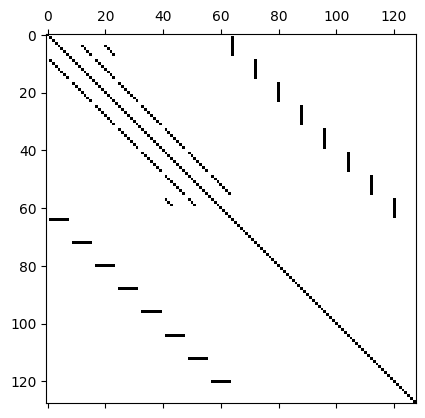

In [32]:
import matplotlib.pyplot as plt


def extract_block_encoding(res):
    """
    Extract the block encoded matrix from the execution results and plot it
    """
    df = res.dataframe
    df = df[(df.block == 0) & (np.abs(df.amplitude) > 1e-12)].copy()
    global_phase = np.angle(df.amplitude.iloc[0])
    df["amplitude_real"] = np.real(df.amplitude / np.exp(1j * global_phase))
    df["amplitude_imag"] = np.imag(df.amplitude / np.exp(1j * global_phase))

    full_mat = 0
    for i, s in enumerate(["real", "imag"]):
        matrix = df.pivot_table(
            index="data", columns="data_ref", values=f"amplitude_{s}", fill_value=0
        )

        # Reindex rows and columns to ensure full coverage
        full_index = np.arange(2 ** (BEData.num_qubits))
        matrix = matrix.reindex(index=full_index, columns=full_index, fill_value=0)
        # Convert to numpy array, add the normalization factor
        matrix_np = matrix.to_numpy() * np.sqrt(2 ** (BEData.num_qubits))
        full_mat += matrix_np.astype("complex128") * [1, 1j][i]
    full_mat = full_mat

    return full_mat


mat_be = extract_block_encoding(res_be)
plt.spy(mat_be)

## Linear solver using QSVT matrix inversion

Now we use the block encoding to solve the equation. We only left to encode the external source we want to solve for as initial state, and apply matrix inversion on the it.

Because the condition number of the resulting matrix is high for our simulation, we limitied ourselves for small grid size, on which the problem solution is not physical, though we show it for educational purposes.

### Initial state Loading
We solve for a source term localized at $x_0$, according to the following formula:
$$
j(S)= i \omega_0 e^{- \frac{(x - x_0)^2}{2 (\Delta_S)^2}}
$$

In [24]:
x_coordinates = np.linspace(0, X_MAX, 2**N_X)
j_amplitudes = W_0 * np.exp(
    -((x_coordinates - X_0) ** 2) / (2 * DS**2)
)  # ignore the i phase
SOURCE_NORM_FACTOR = np.linalg.norm(j_amplitudes)
j_amplitudes /= SOURCE_NORM_FACTOR


@qfunc
def prepare_source_term(data: BEData):
    data.E ^= 1  # source term has non-zero values only for E
    inplace_prepare_amplitudes(j_amplitudes, 0, data.x)

### QSVT phases calculation

Solve an optimization problem for the qsvt polynomial, and find the corresponding QSVT phases:

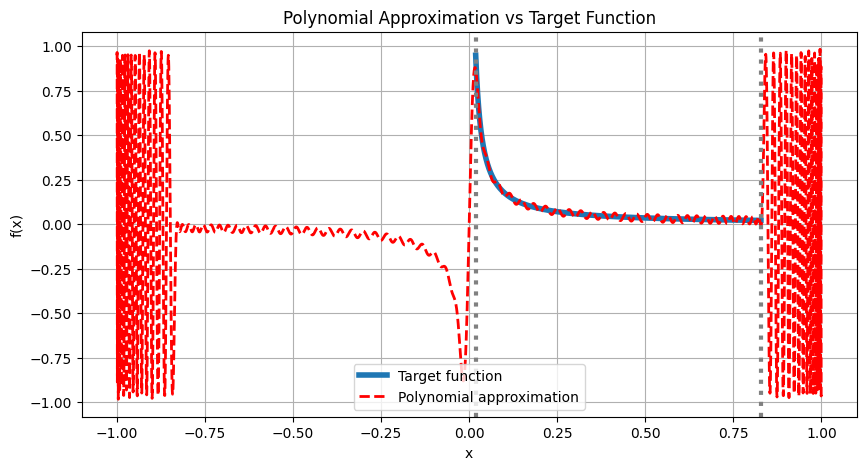

min singular value: 0.01856162144286599, max_singular value: 0.8282275541075902
Max relative error value: 0.02046509592876211


In [25]:
import matplotlib.pyplot as plt

from classiq.applications.qsp import qsp_approximate, qsvt_phases

svd = np.linalg.svd(mat_be)[1]
w_min, w_max = min(svd), max(svd)

DEGREE = 180
# Relaxed constraint
scale = 0.95


def target_function(x):
    return scale * (w_min) / x


pcoefs, opt_res = qsp_approximate(
    target_function,
    degree=DEGREE,
    parity=1,
    interval=[w_min, w_max],
    plot=True,
    bound=0.95,
)

INVERSION_PHASES = qsvt_phases(pcoefs)
print(f"min singular value: {w_min}, max_singular value: {w_max}")
print(f"Max relative error value: {opt_res}")

### Full QSVT circuit

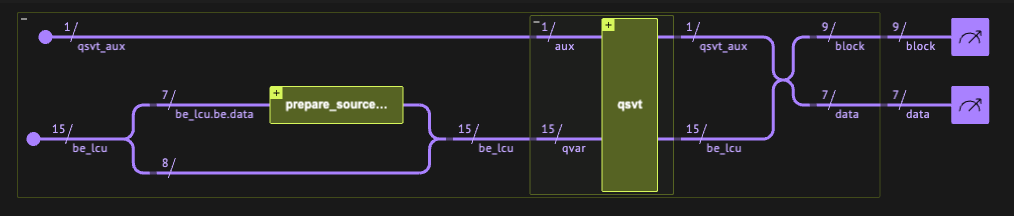

The QSVT projector is just checking whether the entire block is 0.

In [26]:
@qfunc
def projector(block: QNum, res: QBit):
    res ^= block == 0


@qfunc
def main(data: Output[BEData], block: Output[QNum]):
    be_lcu = BELcu()
    qsvt_aux = QBit()

    allocate(be_lcu)
    allocate(qsvt_aux)

    prepare_source_term(be_lcu.be.data)

    qsvt_inversion(
        INVERSION_PHASES,
        lambda aux: projector([be_lcu.be.block, be_lcu.lcu], aux),
        lambda: full_be(be_lcu),
        qsvt_aux,
    )

    bind([be_lcu, qsvt_aux], [data, block])

In [27]:
preferences = Preferences(
    transpilation_option="none",
    debug_mode=False,  # remove this to get better circuit visualization, on the expense of longer synthesis time
    timeout_seconds=20 * 60,
    qasm3=True,
    optimization_level=1,
)

qprog_qsvt = synthesize(
    main,
    preferences=preferences,
    constraints=Constraints(optimization_parameter="width"),
)
print(f"Num qubits: {qprog_qsvt.data.width}")
show(qprog_qsvt)

with ExecutionSession(qprog_qsvt, execution_preferences) as es:
    es.set_measured_state_filter("block", lambda state: state == 0.0)
    res_qsvt = es.sample()

Num qubits: 19
Quantum program link: https://platform.classiq.io/circuit/35YqVgYpFCZf3OMSykrlxGj5ni5


### Post-process

In [28]:
df = res_qsvt.dataframe
df.head(10)

,data.v,data.x,data.E,block,amplitude,magnitude,phase,probability,bitstring
0,1,4,0,0,0.013605+0.000471j,0.01,0.01π,0.000185,0000000000001000010
1,1,3,0,0,0.013603-0.000472j,0.01,-0.01π,0.000185,0000000000000110010
2,-4,3,0,0,0.007906-0.002675j,0.01,-0.10π,0.000070,0000000000000111000
3,-4,4,0,0,0.007903+0.002675j,0.01,0.10π,0.000070,0000000000001001000
4,-3,4,0,0,0.005077+0.002067j,0.01,0.12π,0.000030,0000000000001001010
5,-3,3,0,0,0.005076-0.002069j,0.01,-0.12π,0.000030,0000000000000111010
6,2,4,0,0,0.003209-0.000324j,0.00,-0.03π,0.000010,0000000000001000100
7,2,3,0,0,0.003206+0.000325j,0.00,0.03π,0.000010,0000000000000110100
8,0,2,1,0,0.001109+0.000937j,0.00,0.22π,0.000002,0000000000010100000
9,0,3,1,0,0.001104+0.049842j,0.05,0.49π,0.002485,0000000000010110000


Here we plot the resulting $E$ vector.

Text(0, 0.5, '$|E(x)|$')

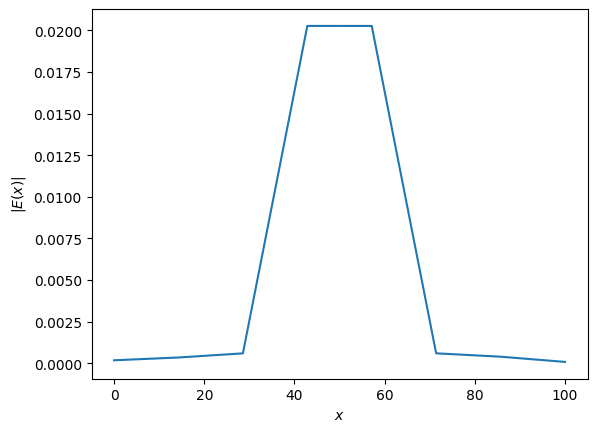

In [29]:
# filter only the E results
df_E = df[
    (df["data.E"] == 1) & (df["data.v"] == 0) & (np.abs(df.amplitude) > 1e-14)
].sort_values(by="data.x")

x_values = df_E["data.x"] * DX
E_values = df_E.amplitude * 1 / min(svd) * SOURCE_NORM_FACTOR / (BE_NORM_FACTOR * scale)
plt.plot(x_values, np.abs(E_values))

plt.xlabel("$x$")
plt.ylabel("$|E(x)|$")

#### Compare to a classical solver

In [30]:
import numpy as np


def get_advective_mat(nx, nv, dx, v_max, cyclic=False):
    dx_mat = np.diag(np.ones(2**nx - 1), k=1) - np.diag(np.ones(2**nx - 1), k=-1)
    boundary = np.pad([-3, 4, -1], (0, dx_mat.shape[1] - 3))
    dx_mat[0, :] = boundary
    dx_mat[-1, :] = -np.flip(boundary)

    v_amplitudes = np.linspace(-1, 1 - 2 ** (-nv + 1), 2**nv) * v_max
    v_amplitudes = np.roll(v_amplitudes, len(v_amplitudes) // 2)

    x_values = np.arange(2**nx)
    max_x = 2**nx - 1
    xi = (
        1
        - np.kron(x_values == 0, v_amplitudes > 0)
        - np.kron(x_values == max_x, v_amplitudes <= 0)
    )

    advective = np.kron(dx_mat / (2 * dx), np.diag(v_amplitudes))
    advective[xi == 0] = 0

    return advective


def get_off_diag_mat(nx, nv, dv, v_max, temp):
    v_amplitudes = np.linspace(-1, 1 - 2 ** (-nv + 1), 2**nv) * v_max
    v_amplitudes = np.roll(v_amplitudes, len(v_amplitudes) // 2)
    v_H_amplitudes = (
        v_amplitudes
        * np.exp(-(v_amplitudes**2) / (2 * temp))
        / (np.sqrt(2 * np.pi * temp))
    )

    vec_col = v_H_amplitudes
    vec_row = v_amplitudes * dv

    n = len(vec_col)
    dim_x = 2**nx
    dim_v = 2**nv
    size = dim_x * dim_v

    A = np.zeros((size, size))
    B = np.zeros((size, size))
    for i in range(dim_x):
        A[i * dim_v : (i + 1) * dim_v, i * dim_v] = vec_col
        B[i * dim_v, i * dim_v : (i + 1) * dim_v] = vec_row

    # Compose off-diagonal block matrix
    top = np.hstack((np.zeros_like(A), -A))
    bottom = np.hstack((B, np.zeros_like(B)))
    off_diag = np.vstack((top, bottom))
    return off_diag


def get_block_encoding(nx, nv, v_max, x_max, w0, temp):
    dx = x_max / (2**nx - 1)
    dv = (2 * v_max) / (2**nv - 1)

    mat_size = 2 ** (nx + nv + 1)
    advective = get_advective_mat(nx, nv, dx, v_max)
    off_diag = get_off_diag_mat(nx, nv, dv, v_max, temp)

    return 1j * w0 * np.eye(mat_size) - np.kron(np.diag([1, 0]), advective) + off_diag


def get_source_term(nx, nv, x0, x_max, w0, ds):
    x_coordinates = np.linspace(0, x_max, 2**nx)
    j_amplitudes = 1j * w0 * np.exp(-((x_coordinates - x0) ** 2) / (2 * ds**2))
    v_0 = np.zeros(2**nv)
    v_0[0] = 1
    source = np.kron([0, 1], np.kron(j_amplitudes, v_0))
    return source


def solve_problem(
    nx, nv, w0, x_max=X_MAX, v_max=V_MAX, temp=Temperature, x0=X_0, ds=DS
):
    be = get_block_encoding(nx, nv, v_max, x_max, w0, temp)
    source = get_source_term(nx, nv, x0, x_max, w0, ds)

    sol = np.linalg.solve(be, source)

    v_0 = np.zeros(2**nv)
    v_0[0] = 1
    E_filter = np.kron([0, 1], np.kron(np.ones(2**nx), v_0)).astype("bool")
    E = sol[E_filter]

    return be, E

Text(0, 0.5, '|E(x)|')

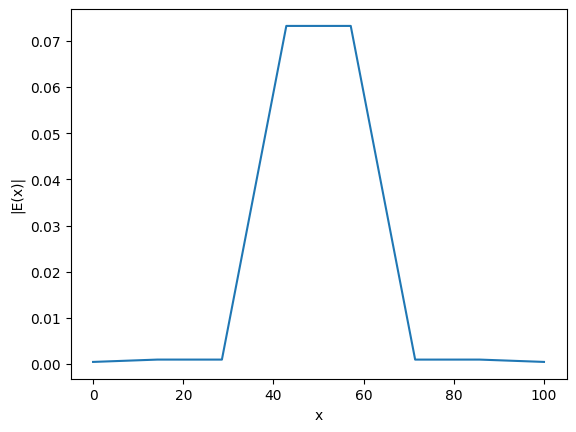

In [31]:
mat_classical, E_classical = solve_problem(N_X, N_V, W_0)

x_coordinates = np.linspace(0, X_MAX, 2**N_X)
plt.plot(x_coordinates, np.abs(E_classical))
plt.xlabel("x")
plt.ylabel("|E(x)|")

## References

<a name='KineticPlasma'>[1]</a>: Novikau, I., Dodin, I.Y., & Startsev, E.A. (2024). *Encoding of linear kinetic plasma problems in quantum circuits via data compression*. **Journal of Plasma Physics**, 90(4). [https://doi.org/10.1017/S0022377824000795](https://doi.org/10.1017/S0022377824000795)

<a name='Tok'>[2]</a>: [Tokamak (Wikipedia)](https://en.wikipedia.org/wiki/Tokamak).

<a name='QSVTPrep'>[3]</a>: McArdle, S., Gilyén, A., & Berta, M. (2025). *Quantum state preparation without coherent arithmetic*. arXiv:2210.14892 [quant-ph]. [https://arxiv.org/abs/2210.14892](https://arxiv.org/abs/2210.14892)

<a name='LinearPrep'>[4]</a>: Gonzalez-Conde, J., Watts, T. W., Rodriguez-Grasa, P., & Sanz, M. (2024). *Efficient quantum amplitude encoding of polynomial functions*. **Quantum**, 8, 1297. [https://doi.org/10.22331/q-2024-03-21-1297](https://doi.org/10.22331/q-2024-03-21-1297)
